In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("churnprediction App").getOrCreate()

23/10/13 21:35:03 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [4]:
!pip install seaborn


Defaulting to user installation because normal site-packages is not writeable


In [18]:
from pyspark.sql.functions import col, when ,count
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot   as plt
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

In [6]:
df = spark.read.csv("WA_Fn-UseC_-Telco-Customer-Churn.csv", header=True, inferSchema=True)

In [7]:
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



In [8]:
df.show(10)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

In [9]:
df.limit(10).toPandas()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


EDA


In [10]:
df = df.withColumn("TotalCharges", col("TotalCharges").cast("double"))

In [11]:
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



In [12]:
df_recreated = spark.read.csv("WA_Fn-UseC_-Telco-Customer-Churn.csv", header=True, inferSchema=True)

In [13]:
df_recreated.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



In [19]:
df_recreated.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|         0|     0|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|              0|       0|               0| 

In [20]:
#converting totalcharges colulm to double 
df_recreated = df_recreated.withColumn("TotalCharges", col("TotalCharges").cast("double"))

In [21]:
df_recreated.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



In [22]:
for column in df_recreated.columns:
    df_recreated.filter(col(column).isNull()).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-

In [23]:
columns_with_missing_values = []

# Iterate over columns and check for null values
for column in df_recreated.columns:
    if df_recreated.filter(col(column).isNull()).count() > 0:
        columns_with_missing_values.append(column)

# Print column names with missing values
print("Columns with missing values: ", columns_with_missing_values)

Columns with missing values:  ['TotalCharges']


In [24]:
totalcharge=df_recreated.select('TotalCharges')
totalcharge.show()

+------------+
|TotalCharges|
+------------+
|       29.85|
|      1889.5|
|      108.15|
|     1840.75|
|      151.65|
|       820.5|
|      1949.4|
|       301.9|
|     3046.05|
|     3487.95|
|      587.45|
|       326.8|
|      5681.1|
|      5036.3|
|     2686.05|
|     7895.15|
|     1022.95|
|     7382.25|
|      528.35|
|      1862.9|
+------------+
only showing top 20 rows



In [25]:
missing_values_count = df_recreated.where(col('TotalCharges').isNull()).count()

print(missing_values_count )

11


In [26]:
df_cleaned = df_recreated.dropna(subset=["TotalCharges"])

In [27]:
df_cleaned.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|  

In [28]:
df_cleaned.count()

7032

In [29]:
df_cleaned.select('customerID').distinct().count()

7032

In [30]:
#types of dependents
DEpendents= df_recreated.select('Dependents').distinct().collect()
print("\n".join(str(DEpendents[i][0]) for i in range(len(DEpendents))))

No
Yes


In [31]:
citizens=df_recreated.select('SeniorCitizen').distinct().collect()
print("\n".join(str(citizens[i][0]) for i in range(len(citizens))))

1
0


In [32]:
paymentmethod=df_recreated.select('PaymentMethod').distinct().collect()
print("\n".join(str(paymentmethod[i][0]) for i in range(len(paymentmethod))))

Credit card (automatic)
Mailed check
Bank transfer (automatic)
Electronic check


Exploration


<Axes: xlabel='PaperlessBilling', ylabel='count'>

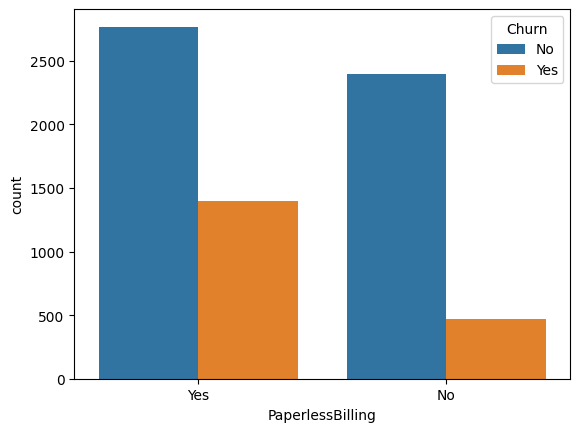

In [33]:

cleaned_df_pandas_dep = df_cleaned.select('PaperlessBilling','Churn').toPandas()

sns.countplot(x='PaperlessBilling', hue='Churn', data=cleaned_df_pandas_dep)

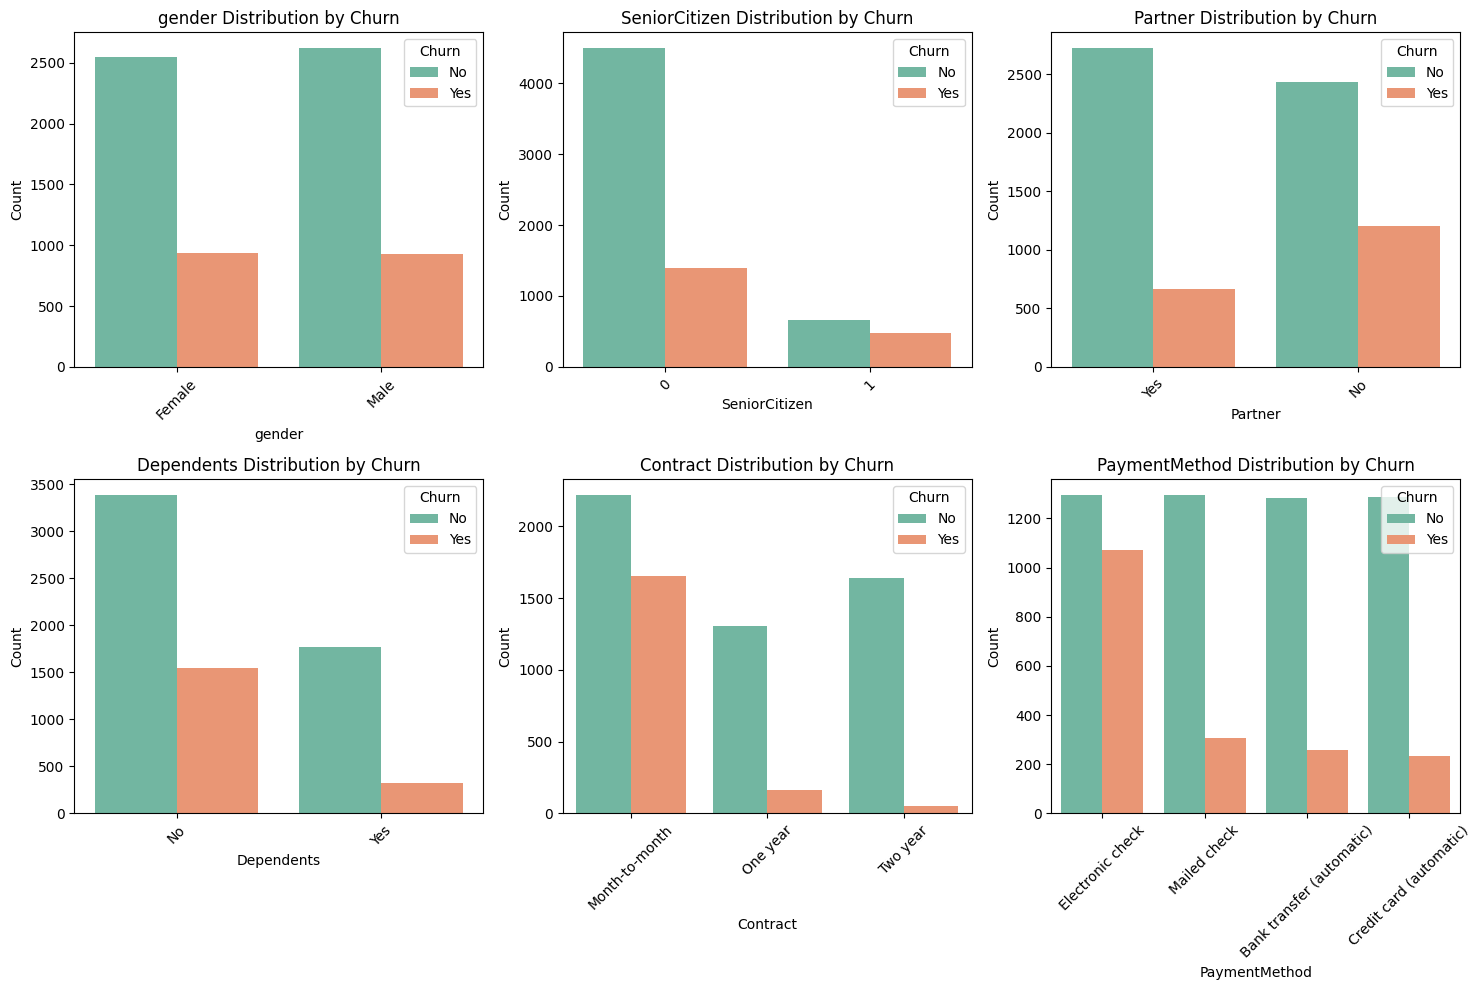

In [35]:
# Plot 3: Categorical Feature Distribution
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Contract', 'PaymentMethod']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 3, i)
    sns.countplot(data=df_cleaned.toPandas(), x=feature, hue='Churn', palette='Set2')
    plt.title(f'{feature} Distribution by Churn')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

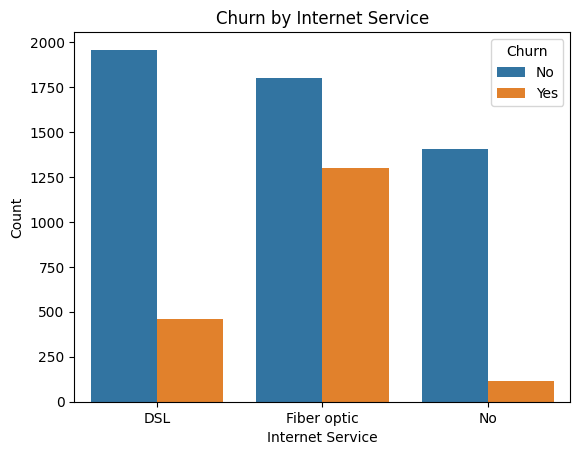

In [36]:
sns.countplot(data=df_cleaned.toPandas(), x='InternetService', hue='Churn')
plt.xlabel("Internet Service")
plt.ylabel("Count")
plt.title("Churn by Internet Service")
plt.show()

<Figure size 1600x1400 with 0 Axes>

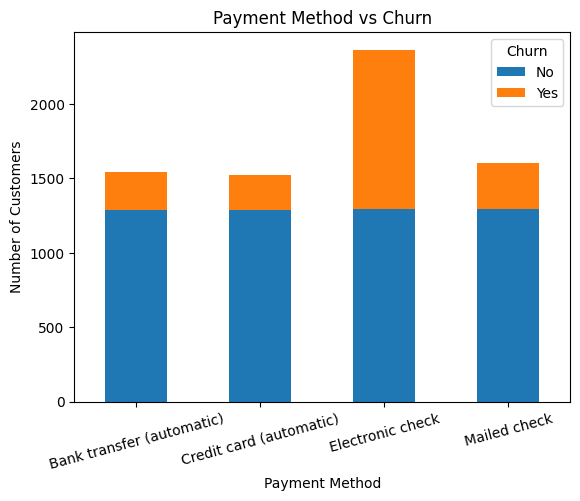

In [37]:
# create a contingency table of PaymentMethod and Churn
df_cleaned_pandas=df_cleaned.toPandas()
payment_churn_table = pd.crosstab(df_cleaned_pandas['PaymentMethod'], df_cleaned_pandas['Churn'])

plt.figure(figsize=(16,14))
# create a stacked bar plot
payment_churn_table.plot(kind='bar', stacked=True)

# set plot title and axis labels
plt.title('Payment Method vs Churn')
plt.xlabel('Payment Method')
plt.ylabel('Number of Customers')

plt.xticks(rotation=15)

# display the plot
plt.show()

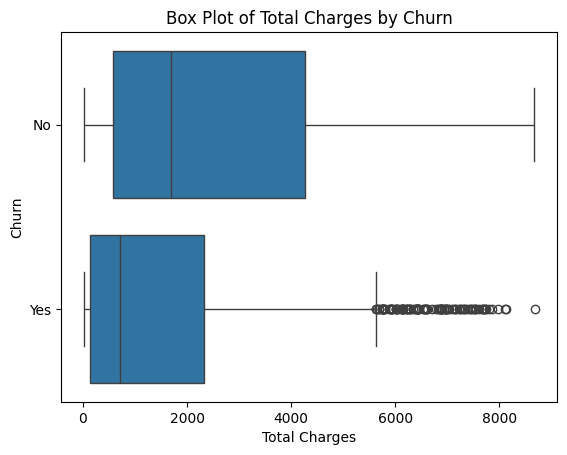

In [38]:
# create a box plot using boxplot() function
sns.boxplot(x="TotalCharges", y="Churn", data=df_cleaned.toPandas())

# set x-axis and y-axis labels and plot title
plt.xlabel("Total Charges")
plt.ylabel("Churn")
plt.title("Box Plot of Total Charges by Churn")

# display the plot
plt.show()


In [39]:
from pyspark.ml.stat import Correlation

23/10/13 21:41:02 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


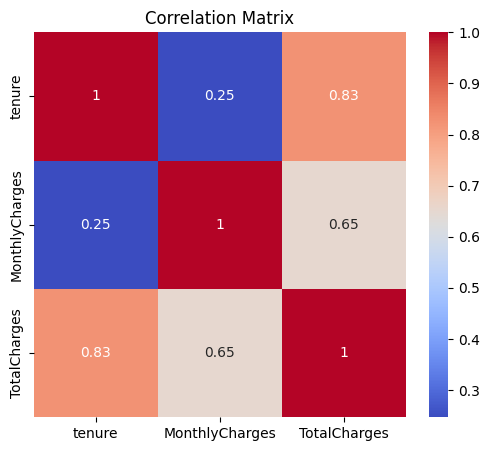

In [40]:

numerical_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Assemble the features into a single vector column
assembler = VectorAssembler(inputCols=numerical_columns, outputCol='features')
assembled_df = assembler.transform(df_cleaned).select('features')

# Compute the correlation matrix
correlation_matrix = Correlation.corr(assembled_df, 'features').head()

# Extract the correlation matrix as a dense matrix
correlation_matrix = correlation_matrix[0].toArray()

# Visualize the correlation matrix using Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', xticklabels=numerical_columns, yticklabels=numerical_columns)
plt.title("Correlation Matrix")
plt.show()


In [41]:
cleaned_df_pandas_num = df_cleaned.select('tenure', 'monthlycharges', 'totalcharges','Churn').toPandas()


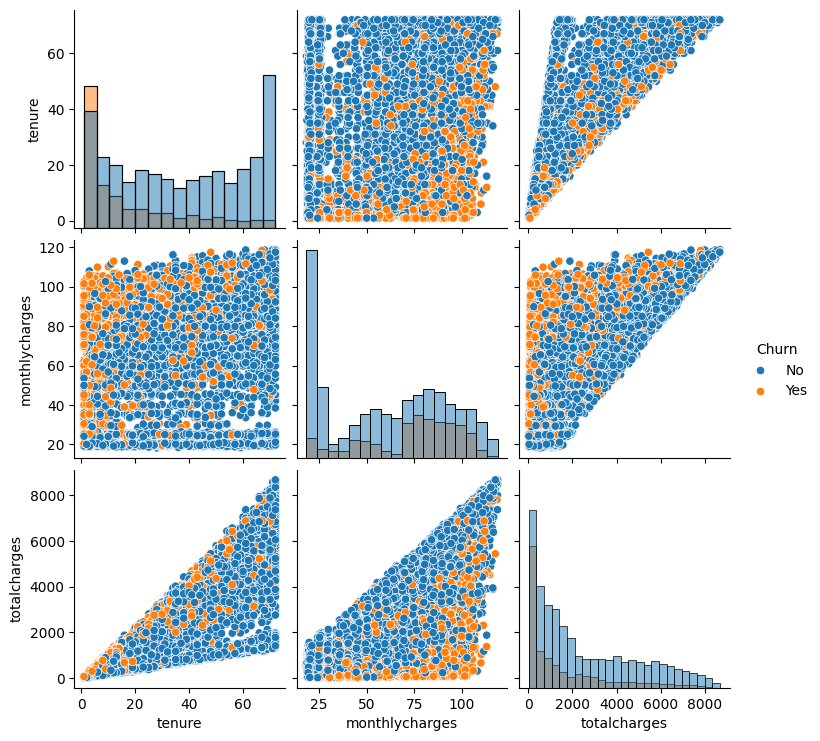

In [42]:
sns.pairplot(cleaned_df_pandas_num, hue='Churn', diag_kind='hist')
plt.show()

Transformation and feature engineering


In [43]:
df2 = df_cleaned.withColumn('Churn', when(col('Churn') == 'Yes', 1).otherwise(0))

In [44]:
df2.show(10)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

In [45]:

# List of categorical columns
categorical_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Contract', 'PaymentMethod']

# String indexing and one-hot encoding for categorical features
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid="keep") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_encoded") for col in categorical_cols]

# Assemble categorical features into a single vector column
assembler_cat = VectorAssembler(inputCols=[col + "_encoded" for col in categorical_cols], outputCol="cat_features")

# Create a pipeline for categorical transformations
categorical_pipeline = Pipeline(stages=indexers + encoders + [assembler_cat])

# Fit and transform the categorical pipeline on the data
categorical_transformed = categorical_pipeline.fit(df2).transform(df2)


In [47]:
from pyspark.ml.feature import StandardScaler
# List of numerical columns
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Assemble numerical features into a single vector column
assembler_num = VectorAssembler(inputCols=numerical_cols, outputCol="num_features")

# Standard scaling for numerical features
scaler = StandardScaler(inputCol="num_features", outputCol="scaled_features", withStd=True, withMean=True)

# Create a pipeline for numerical transformations
numerical_pipeline = Pipeline(stages=[assembler_num, scaler])

# Fit and transform the numerical pipeline on the data
numerical_transformed = numerical_pipeline.fit(categorical_transformed).transform(categorical_transformed)


In [48]:
# Assemble categorical and numerical features into a single vector column
assembler = VectorAssembler(inputCols=["cat_features", "scaled_features"], outputCol="features")

# Assemble features for the entire dataset
final_data = assembler.transform(numerical_transformed).select("features", "Churn")


In [49]:
final_data.show(10)

+--------------------+-----+
|            features|Churn|
+--------------------+-----+
|(18,[1,2,5,6,8,11...|    0|
|(18,[0,2,4,6,10,1...|    0|
|(18,[0,2,4,6,8,12...|    1|
|(18,[0,2,4,6,10,1...|    0|
|(18,[1,2,4,6,8,11...|    1|
|(18,[1,2,4,6,8,11...|    1|
|(18,[0,2,4,7,8,14...|    0|
|(18,[1,2,4,6,8,12...|    0|
|(18,[1,2,5,6,8,11...|    1|
|(18,[0,2,4,7,10,1...|    0|
+--------------------+-----+
only showing top 10 rows



In [52]:
# Split the data into training and testing sets
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

# Instantiate Logistic Regression model
lr = LogisticRegression(featuresCol='features', labelCol='Churn')
lr_Model =lr.fit(train_data)







In [54]:
# Make predictions on the test data
predictions = lr_Model.transform(test_data)

evaluating predictions 


In [55]:


# Assuming 'predictions' contains the DataFrame with prediction results

# Binary Classification Evaluator for accuracy and area under ROC
evaluator_binary = BinaryClassificationEvaluator(labelCol='Churn')
auc = evaluator_binary.evaluate(predictions, {evaluator_binary.metricName: "areaUnderROC"})

# Multiclass Classification Evaluator for F1-score
evaluator_multiclass = MulticlassClassificationEvaluator(labelCol='Churn')
f1_score = evaluator_multiclass.evaluate(predictions, {evaluator_multiclass.metricName: "f1"})
print("Area Under ROC:", auc)
print("F1-Score:", f1_score)


Area Under ROC: 0.8331229651466496
F1-Score: 0.7861969797633532


In [56]:
import numpy as np 

# Extracting true labels and predicted labels as RDDs
true_labels = predictions.select('Churn').rdd.map(lambda row: float(row.Churn))
predicted_labels = predictions.select('prediction').rdd.map(lambda row: float(row.prediction))

# Create a MulticlassMetrics object
metrics = MulticlassMetrics(predicted_labels.zip(true_labels))

# Calculate confusion matrix
confusion_matrix = np.array(metrics.confusionMatrix().toArray())

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix)


/opt/spark/spark-3.5.0-bin-hadoop3/python/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
[[884.  97.]
 [178. 183.]]
